# Solving Single Decisions

## The "Party Problem" example

JMA 11 Jan 2024

In [42]:
# Imports from the python standard library
import math, re, os, sys 
from pathlib import Path
import itertools            # to flatten lists

# Import array and dataframe packages
import numpy as np
# import numpy.linalg as la
import pandas as pd
import torch

import networkx as nx

# Use to parse xdsl files
import xml.etree.ElementTree as et

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sn 
# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, VBar, Span
from bokeh.io import output_notebook
output_notebook()

NETWORK_FILE = 'PartyProblem_asym.xdsl' # 'PartyProblem_asym.xdsl'  # 

Loading BokehJS ...

In [43]:
##  Walk the xdsl elements of a network
def extract_net(xdsl_file):
    '''Finds the first element under the top level that contains a list of nodes,
    and returns a dict of node element objects.'''
    tree = et.parse(xdsl_file)
    root = tree.getroot()
    # BN structure is contained under the node element
    node_tree = root.findall('nodes')[0]
    print(f'found {node_tree.tag}')
    extensions = root.find('extensions')
    extensions_tree = extensions.find('genie')
    node_extensions = extensions_tree.findall('node')
    return  list(node_tree), list(node_extensions)
    
# BN structure is contained under the node branch
parsed = extract_net(NETWORK_FILE)
nodes, extensions = parsed
# tags tell the node type. 
[( k.get('id'), k.tag) for k in nodes]

found nodes


[('Party_location', 'decision'),
 ('Weather', 'cpt'),
 ('Preferences', 'utility'),
 ('Utility', 'maux'),
 ('Adjustor', 'cpt'),
 ('Detector', 'cpt')]

In [44]:
# view the XML of an element
# CPT contents are stored in row major order (first row, second row, ...)
# Parents are the first matrix dimension -- matrix is Row Markov
# et.dump(
parsed
     # nodes[2])

([<Element 'decision' at 0x1381707c0>,
  <Element 'cpt' at 0x138170b30>,
  <Element 'utility' at 0x138170ea0>,
  <Element 'maux' at 0x138170f90>,
  <Element 'cpt' at 0x1381710d0>,
  <Element 'cpt' at 0x1381c7b00>],
 [<Element 'node' at 0x138153fb0>,
  <Element 'node' at 0x13820b790>,
  <Element 'node' at 0x138223c90>,
  <Element 'node' at 0x138223d30>,
  <Element 'node' at 0x138223a60>,
  <Element 'node' at 0x138223880>])

## Bayes networks object

It contains 

- the parse of the network as a dictionary with node names as keys
- The graph object showing network structure
- Potential objects for computation. 



In [45]:
# CPT parent order
# Dimensions are stored in matrix dimension order. 
[et.dump(n) for n in nodes]

<decision id="Party_location">
			<state id="Outdoors" />
			<state id="Porch" />
			<state id="Indoors" />
		</decision>
		
<cpt id="Weather">
			<state id="Sunshine" />
			<state id="Rain" />
			<probabilities>0.4 0.6</probabilities>
		</cpt>
		
<utility id="Preferences">
			<parents>Weather Party_location</parents>
			<utilities>100 90 40 0 20 50</utilities>
		</utility>
		
<maux id="Utility">
			<parents>Preferences</parents>
			<expression>4/3*(1-0.5^(Preferences/50))</expression>
		</maux>
		
<cpt id="Adjustor">
			<state id="absent" />
			<state id="ppresent" />
			<probabilities>0.1 0.9000000000000001</probabilities>
		</cpt>
		
<cpt id="Detector">
			<state id="SaySun" />
			<state id="SayRain" />
			<parents>Weather Adjustor</parents>
			<probabilities>0.51 0.49 0.87 0.13 0.48 0.52 0.4000000000000001 0.6</probabilities>
		</cpt>
	


[None, None, None, None, None, None]

### Include state and variable names to tensor dimensions

In [46]:
# Create a labelled dimension object.
from collections import OrderedDict

class Potential:

    def __init__(self, cpt, shape):
        ' cpt  - multidim tensor, shape: OrderedDict '
        self.p = cpt
        self.shape = shape
        self.dim_names = shape.keys()

    def __repr__(self):
        return str(self.shape) + '\n\t' + repr(self.p)
    
def new_Potential(prob_list, dim_list, dim_names ):
    'factory for creating potential from parsed xml components'
    p = torch.tensor(prob_list).reshape(dim_list)
    sh = OrderedDict(zip(dim_names, dim_list))
    return Potential(p, sh)
    
def get_potential(a_node, n_dict):
    'Find the probability np array in the node, and label it using parents in the graph'
    # The states of the RV label the columns, so that the matrix is row-markov
    the_cpt = n_dict[a_node]['potential']
    return the_cpt

# Place margin probabilities in the last dimension
md = new_Potential([0.1, 0.9, 0.4, 0.6], [2,2], ['condition', 'margin'])
md

OrderedDict({'condition': 2, 'margin': 2})
	tensor([[0.1000, 0.9000],
        [0.4000, 0.6000]])

In [47]:
# Parsing routines
# NOTE: all extract_* functions have side-effects that modify node_dict
class BN (object):

    def __init__(self, name_dict={}):
        self.n_dict = name_dict
        self.network = None
        # Build a reverse topological order to the DAG
        self.node_order = None
        self.edges = None

    def set_kind(self, a_node):
        'Both create the node key and its kind.' 
        self.n_dict[a_node.get('id')] = {'kind': a_node.tag}

    def extract_parents(self, a_node):
        parent_list = []
        p = a_node.find('parents')
        if p is not None:
            parent_list = p.text.split(' ') 
        self.n_dict[a_node.get('id')]['parents' ] = parent_list
        return self.n_dict

    def extract_states(self, a_node):
        state_list = []
        for element in a_node:
            if element.tag == 'state':
                state_list.append(element.get('id'))
        self.n_dict[a_node.get('id')]['states' ] = state_list
        return self.n_dict

    def state_size(self, node_name):
        # Deterministic nodes such as utilities have only one state. 
        
        # if a_node.tag == 'utilities':
        #     return 1
        # else:
        #     node_name = a_node.get('id') 
        return len(self.n_dict[node_name]['states'])

    def get_parents(self, a_node):
        return self.n_dict[a_node]['parents' ]
    
    def build_tensor(self, a_node, elements):
        node_name = a_node.get('id')
        dim_names = [node_name]
        # Need the parents to dimension the cpt
        state_counts = [self.state_size(node_name)]    
        parents = self.get_parents(node_name)
        dim_names.extend(parents)  
        for p in parents:
            state_counts.append(self.state_size(p))      #list of dimensions
        # print('S', state_counts)
        try:
            # if len(prob_list) == state_counts[0]:             # One dimension, no conditioning 
            potential = new_Potential(elements, state_counts, dim_names)   
            #     cpt = torch.tensor(prob_list).reshape(state_counts)
            self.n_dict[node_name]['potential' ] = potential
        except Exception as e:
            print('Err ', e)
            print(f'list of len {elements} is not a consistent with {state_counts}.')

    def extract_probabilities(self, a_node):
        # Probabilities are stored as a flat list, in row major order, e.g. 
        # for each conditioning, the probs for each state are listed together
        # sequentially. 
        p = a_node.find('probabilities')
        if p is not None:
            prob_list = [float(k) for k in p.text.split(' ')]
            self.build_tensor(a_node, prob_list)
        # except Exception as e:
        #     print('Err ', e)
        #     print(f'list of len {prob_list} is not a consistent with {state_counts}.')
        return self.n_dict

    def extract_utilities(self, a_node):
        u = a_node.find('utilities')
        self.n_dict[a_node.get('id')]['states' ] = ['utility']   # a dimension with just one state. 
        if u is not None:
            u_list = [float(k) for k in u.text.split(' ')]
            self.build_tensor(a_node, u_list)
            # TODO The utilities list dimension with  parent states. 
        # self.n_dict[a_node.get('id')]['utilities' ] = u_list
        return self.n_dict

    # Note: Node extensions also have the display name of the node, which is an
    # alternative to it's id. 
    def extract_positions(self, a_node_extension):
        u = a_node_extension.find('position')
        if u is not None:
            u_list = [int(k) for k in u.text.split(' ')]
            # The utilities list cannot be dimensioned until we know it's parent states. 
        self.n_dict[a_node_extension.get('id')]['position' ] = u_list
        return self.n_dict

    # Create an a-cyclic graph from the parents of each node. 

    def weave(self):
        'From the reaped list of nodes connect them into a network.'
        # Assemble edge lists
        edges = []
        for (k, attr) in self.n_dict.items():
            parents = self.get_parents(k)
            if len(parents) > 0:
                [edges.append((z, k )) for z in parents] # Arc direction: z -> k
        print('Edges: ',edges, '\n')
        self.edges = edges
        return edges
    
    # def get_tensor(self, variable):
    #     return self.n_dict[variable]['potential']
    
# create a BN object from the parsing 
def reap(the_parse):
    'Factory to parse the attributes of each node, returning a list with the attributes in a dict.'
    bn = BN()
    the_nodes, the_extensions = the_parse
    for a_node in the_nodes:
        # Set the node kind
        bn.set_kind(a_node)
        # node_dict[a_node.get('id')] = {'kind': a_node.tag}
        bn.extract_parents(a_node)
        # CPT and decision nodes have states
        if (a_node.tag == 'cpt') or (a_node.tag == 'decision'):
            bn.extract_states(a_node)
        if (a_node.tag == 'cpt'):
            bn.extract_probabilities(a_node)
        if (a_node.tag == 'utility'):
            bn.extract_utilities(a_node)
    for an_ex in the_extensions:
        bn.extract_positions(an_ex)
    bn.edges = bn.weave()
    return bn

bn = reap(parsed)
bn.n_dict

Edges:  [('Weather', 'Preferences'), ('Party_location', 'Preferences'), ('Preferences', 'Utility'), ('Weather', 'Detector'), ('Adjustor', 'Detector')] 



{'Party_location': {'kind': 'decision',
  'parents': [],
  'states': ['Outdoors', 'Porch', 'Indoors'],
  'position': [245, 268, 324, 324]},
 'Weather': {'kind': 'cpt',
  'parents': [],
  'states': ['Sunshine', 'Rain'],
  'potential': OrderedDict({'Weather': 2})
  	tensor([0.4000, 0.6000]),
  'position': [298, 119, 408, 174]},
 'Preferences': {'kind': 'utility',
  'parents': ['Weather', 'Party_location'],
  'states': ['utility'],
  'potential': OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
  	tensor([[[100.,  90.,  40.],
           [  0.,  20.,  50.]]]),
  'position': [435, 281, 573, 329]},
 'Utility': {'kind': 'maux',
  'parents': ['Preferences'],
  'position': [660, 279, 746, 327]},
 'Adjustor': {'kind': 'cpt',
  'parents': [],
  'states': ['absent', 'ppresent'],
  'potential': OrderedDict({'Adjustor': 2})
  	tensor([0.1000, 0.9000]),
  'position': [62, 81, 174, 116]},
 'Detector': {'kind': 'cpt',
  'parents': ['Weather', 'Adjustor'],
  'states': ['SaySun', 'SayRa

### Add graph structure

In [48]:
# Create a plotable graph
G = nx.DiGraph(bn.edges)

for n in G:
    print(n, ': ',nx.ancestors(G,n), '\t', nx.descendants(G,n), '\n')
#     nx.nodes(G)

Weather :  set() 	 {'Preferences', 'Utility', 'Detector'} 

Preferences :  {'Weather', 'Party_location'} 	 {'Utility'} 

Party_location :  set() 	 {'Preferences', 'Utility'} 

Utility :  {'Preferences', 'Weather', 'Party_location'} 	 set() 

Detector :  {'Weather', 'Adjustor'} 	 set() 

Adjustor :  set() 	 {'Detector'} 



In [49]:
# The networkX object does not contain the node attributes extracted from the XDSL
DG = nx.DiGraph(bn.edges)
DG.nodes()

NodeView(('Weather', 'Preferences', 'Party_location', 'Utility', 'Detector', 'Adjustor'))

In [50]:
def node_centers(node_dict):
    xmax = ymax = - pow(2,16)
    xmin = ymin =   pow(2,16)
    center_dict = {}
    for k,attr in node_dict.items():
        v = attr['position']
        x = (v[0] + v[2])/2
        y = -(v[1] + v[3])/2
        center_dict[k]  = np.array((x,y))
        xmin = min(x, xmin)
        ymin = min(y, ymin)
        xmax = max(x, xmax)
        ymax = max(y, ymax)
    return center_dict

positions = node_centers(bn.n_dict) 
positions

{'Party_location': array([ 284.5, -296. ]),
 'Weather': array([ 353. , -146.5]),
 'Preferences': array([ 504., -305.]),
 'Utility': array([ 703., -303.]),
 'Adjustor': array([118. , -98.5]),
 'Detector': array([ 165. , -202.5])}

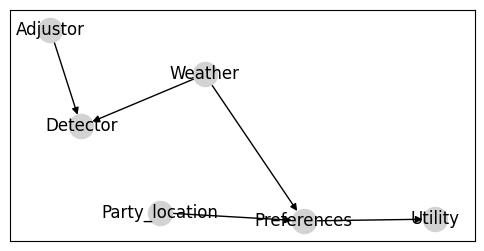

In [51]:
plt.figure(figsize=(6,3))
nx.draw_networkx_labels(DG, pos=positions)
nx.draw_networkx_nodes(DG, pos=positions, node_color='lightgrey')
nx.draw_networkx_edges(DG, pos=positions)

### Extract matrices as tensors.  _List all tensors_

In [52]:
# See p. 270, Howard & Abbas
# P( detector | weather)

def pr_node_tensor(the_n):
    print(a_node, '\n\t', get_potential(the_n, bn.n_dict),'\n')


def pr_named_tensors(name_dict = bn.n_dict):
    'Show all the model tensors'
    for a_node in name_dict:
        if name_dict[a_node]['kind'] == 'cpt' or name_dict[a_node]['kind'] == 'utility':
            print(a_node, '\n\t', get_potential(a_node, bn.n_dict),'\n')

pr_named_tensors(bn.n_dict)

Weather 
	 OrderedDict({'Weather': 2})
	tensor([0.4000, 0.6000]) 

Preferences 
	 OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]]) 

Adjustor 
	 OrderedDict({'Adjustor': 2})
	tensor([0.1000, 0.9000]) 

Detector 
	 OrderedDict({'Detector': 2, 'Weather': 2, 'Adjustor': 2})
	tensor([[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]) 



In [53]:
# Format one-dim tensors 
# from collections import deque
def one_dim_table(the_potential, the_var, n_dict=bn.n_dict, **args):
    def que_copy(prefix, queue):
       if not isinstance(queue, list):
           queue = [queue]
       queue.insert(0, prefix)
       return queue
    states = n_dict[the_var]['states']
    values = the_potential.tolist()
    # Flatten nested lists
    while len(values)  == 1:   # TODO is this test necessary?
        values = values[0]
    print(f' *** {the_var} ***')
    values = [que_copy(s, v) for s, v in zip(states, values)]
    print(tabulate(values, **args))

one_dim_table(get_potential('Weather', bn.n_dict).p, 'Weather', tablefmt= 'pipe', headers= ['State', 'Value'])
# get_potential('Weather', bn.n_dict).p.tolist()


 *** Weather ***
| State    |   Value |
|:---------|--------:|
| Sunshine |     0.4 |
| Rain     |     0.6 |


In [54]:
## For joining by aligning potentials as named tensors

def dim_index(potential_cpt, candidate):
    # Starting with 0 as the first location, so the last location equals the length of the shape
    cpt_dims = potential_cpt.dim_names
    # if its included is it not already last?
    if candidate in cpt_dims and candidate != list(cpt_dims)[-1]:
        return list(cpt_dims).index(candidate) 
    else:
        # Either candidate not found or its already at the end, so do nothing.
        return None

def move_named_dim_to_end(the_named_tensor, the_dimension):
    'Transpose the potential place the dimension last'
    the_dim_index = dim_index(the_named_tensor, the_dimension)
    if the_dim_index is not None:
        # Create a modified shape OrderedDict
        shape = the_named_tensor.shape.copy()
        shape.move_to_end(the_dimension)
        # Rotate the tensor dimensions
        p_transpose = list(range(len(shape)))               # The unperturbed list
        p_transpose.append(p_transpose.pop(the_dim_index))  # Move index to end
        # Transpose CPT
        x = the_named_tensor.p.permute(p_transpose)
        return Potential(x, shape)
    else:
        # A no op
        return the_named_tensor 
    
def marginalize_last(p1, p2):
    '''For a potential matching the last dimension of the other, join them,
    then marginalized out the last dimension'''
    if list(p1.shape)[-1] != list(p2.shape)[-1]:           # Compare shapes by indexed value
        print(f'Err, last shapes do not match:\t{list(p1.shape)[-1]} != {list(p2.shape)[-1]}')
        return None
    else:
        new_tensor = (p1.p * p2.p).sum(-1)
        # The symmetric set difference - those not common to both. 
        s1 = set(p1.shape.items())
        s2 = set(p2.shape.items())
        new_shape = OrderedDict(s1.union(s2) - s1.intersection(s2))
    return Potential(new_tensor, new_shape)

### Utilities

In [57]:
# Utility matrix, as a Potential
outcome_potential = get_potential('Preferences', bn.n_dict)
outcome_potential

OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]])

In [58]:
# No problem with mapping single arg functions over tensors!  
def delta_utility(x, exponand = 0.5, normalize = 50):
    dims = x.shape
    u = 4/3*(1 - pow(exponand, (x.p/normalize)))
    return Potential(u, dims)

u = delta_utility(outcome_potential)
u

OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[1.0000, 0.9504, 0.5675],
         [0.0000, 0.3229, 0.6667]]])

## Solving the party problem

To determine the optimal policy

* join Detector and Weather CPTs 
* join DW with Utility (Decision is implicit in Utility, w/ unit values for all options)
* marginalize out unobserved Weather (or do this after decn, to get VOI)
* Maximize over options

### First solution - only prior, no observation 

In [60]:
# Note that marginalize_last is symmetric in its arguments. 

preference_transpose = move_named_dim_to_end(get_potential("Preferences", bn.n_dict), "Weather")
preference_transpose


OrderedDict({'Preferences': 1, 'Party_location': 3, 'Weather': 2})
	tensor([[[100.,   0.],
         [ 90.,  20.],
         [ 40.,  50.]]])

In [61]:
prior_utility = marginalize_last(preference_transpose, get_potential("Weather",bn.n_dict))
one_dim_table(prior_utility.p, 'Party_location') 

 *** Party_location ***
--------  --
Outdoors  40
Porch     48
Indoors   46
--------  --


In [62]:
# pre_posterior, shape =  weather_cpt.p @ detector_cpt.p.permute(2,0,1) @ adjustor_cpt.p
# pre_posterior

def marginalize(child_potential, parent_potential):
    cpt = (child_potential.p * parent_potential.p).sum(-1)
    # TODO remove parent shape from child
    sh = OrderedDict(set(child_potential.shape.items()) - set(parent_potential.shape.items()))
    return Potential(cpt, sh)

def shift_to_end(the_shape, the_var):
    the_shape.move_to_end(the_var)
    return the_shape


def join_parent(the_conditional, the_parent, name_dict= bn.n_dict):
    'Assume the parent rv is the last dim in the conditional, and marginalize out that dim'
    # Find the parent and transpose it to last dim
    c_potential = get_potential(the_conditional, name_dict)
    p_potential = get_potential(the_parent, name_dict)
    found_dim = dim_index(c_potential,the_parent)
    # Is found dim not already in the last dim? 
    new_shape = c_potential.shape
    if found_dim is not None:   # TODO does this work if the found dim is first?
        # Move found_dim to last dimension
        new_shape = shift_to_end(new_shape, the_parent)
        c_transpose = list(range(len(new_shape)))
        c_transpose.append(c_transpose.pop(found_dim))
        # Transpose CPT
        c_potential.p.permute(c_transpose)
        # TODO - create a new potential? 
    new_joint =  Potential(c_potential.p * p_potential.p, new_shape)
    return new_joint

    # return the joint potential, with the conditioning prob last. 
# join_parent(marginalize_parent(detector_cpt.permute(2,1,0), adjustor_cpt), weather_cpt)
dw_joint = join_parent("Detector", 'Weather')
dw_joint


OrderedDict({'Detector': 2, 'Adjustor': 2, 'Weather': 2})
	tensor([[[0.2040, 0.2940],
         [0.3480, 0.0780]],

        [[0.1920, 0.3120],
         [0.1600, 0.3600]]])

In [63]:
# P( Weather | Detector) - column markov
# See p 270 Figure 13.6
#   Transpose the joint to get the Detector in last dim, and normalize 
pre_posterior_p = dw_joint.p.sum(-1) 
p = dw_joint.p.transpose(0,1) * (1/pre_posterior_p)
# reverse the shape 
posterior = Potential(p, OrderedDict(list(reversed(dw_joint.shape.items()))) )
print(pre_posterior_p, '\n\n', posterior)



tensor([[0.4980, 0.4260],
        [0.5040, 0.5200]]) 

 OrderedDict({'Weather': 2, 'Adjustor': 2, 'Detector': 2})
	tensor([[[0.4096, 0.6901],
         [0.3810, 0.6000]],

        [[0.6988, 0.1831],
         [0.3175, 0.6923]]])


In [64]:
# One approach is to add a unsqueeze dim to match Detector at the end of preference transpose
# BINGO
extended_preference = preference_transpose.p.unsqueeze(-1)
print(extended_preference.shape)
# Sum out the weather dimension
policy_values = (extended_preference * posterior.p).sum(2)
print('E[ V | Party_location, Detector] = ')
policy_values
# Next we need to weight the optimal in each column by the pre-posterior.

torch.Size([1, 3, 2, 1])


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [65]:

detector_states= bn.n_dict['Detector']['states'].copy()
detector_states.insert(0, 'State')
one_dim_table(policy_values.squeeze(0), 
    'Party_location', 
    floatfmt= ".3f", 
    headers= detector_states)
        

NameError: name 'policy_values' is not defined

In [66]:
policy_values_2d = pd.DataFrame(policy_values.squeeze(0), 
                                columns = bn.n_dict['Detector']['states'], 
                                index = bn.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d, annot=True, xticklabels=True, yticklabels=True)

NameError: name 'policy_values' is not defined

In [ ]:
# Find the max value in each column. 
decn = policy_values.max(1)
decn.values, decn.indices

In [67]:
# Value with information. 
# However utility should be applied after computing expected values to get certain equivalents
# sigh
# 0.7782 * 0.44 + 0.6557 * 0.56
decn.values @ get_potential('Weather', bn.n_dict).p

NameError: name 'decn' is not defined